
# AIA Plotting Tutorial



#### Andy To (MSSL/UCL) -  January 2023


This tutorial will demonstrate how to download and plot AIA data using sunpy.

For more detailed and addtional functionalities, sunpy has a comprehensive library online (https://sunpy.org/). 


#### Installation and Requirements

If this is the first few times using Python, there are several things needed to get this going. Install the following:

Software:
`anaconda python3 pip3`

Python packages: - use `pip3 install astropy numpy sunpy matplotlib`

In [67]:
# Python is very modular, so you import packages before using them.

import os

import astropy
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import sunpy.io.fits
import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.image import coalignment
from astropy.coordinates import SkyCoord
from astropy.visualization import ImageNormalize, quantity_support
from sunpy.net import Fido,attrs

from aiapy.calibrate import correct_degradation, update_pointing
from pathlib import Path



Define the time you want your AIA map to be

In [2]:
aia_time = astropy.time.Time('2016-05-20T00:00:00')


Loading the requests to fetch AIA data. You can change these for different instruments and passbands! For example, 193 A looks at plasma around 1.5MK, and it shows coronal holes very well. But for filament you will want to look at 304 A, and for flares mayeb 94 A.

In [4]:
aia_request = ((attrs.Instrument.aia)
                 & attrs.Wavelength(193*u.angstrom)
                 & attrs.Sample(5*u.minute))


Finally we can fetch our data online!

In [5]:
q = Fido.search(attrs.Time(aia_time-1*u.minute, aia_time+1*u.minute),
                aia_request)


Fido.fetch will find a list of results online. All we have to do is the download them into the folder 'data/'.

In [6]:
files = Fido.fetch(q, path='data/')


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia_lev1_193a_2016_05_19t23_59_05_84z_image_lev1.fits:   0%|          | 0.00/11.6M [00:00<?, ?B/s]

In [9]:
m_aia = sunpy.map.Map(files)


We can look at the data by directly calling our sunpy map variable.

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,193.0 Angstrom
Wavelength,193.0 Angstrom
Observation Date,2016-05-19 23:59:05
Exposure Time,1.999637 s
Dimension,[4096. 4096.] pix
Coordinate System,helioprojective
Scale,[0.600714 0.600714] arcsec / pix
Reference Pixel,[2040.72998 2045.550049] pix

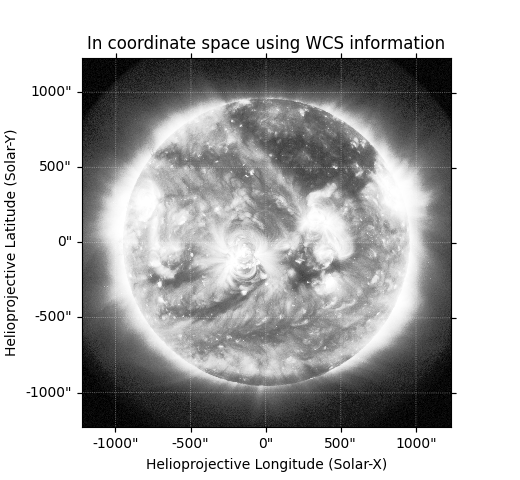
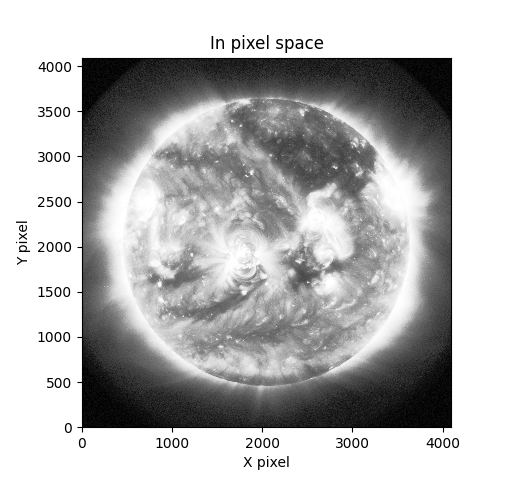
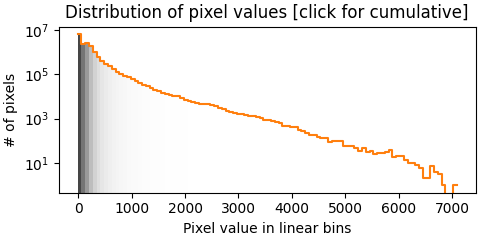
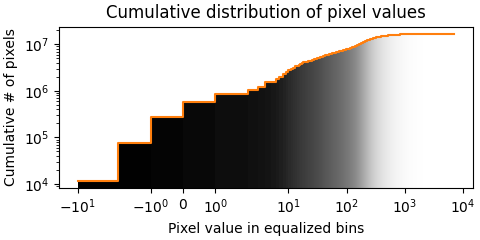

In [11]:
m_aia

Or we can peek the data by doing:

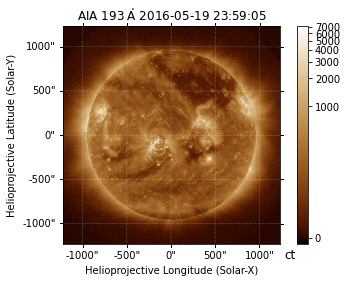

In [13]:
m_aia.peek()

### Preping the data

One interesting thing to analyse spacecraft data is that we need to "prepare" the data. These steps correct the spacecraft's pointing, missing pixel, etc.

In [14]:
m_aia = correct_degradation(update_pointing(m_aia))

/Users/ato/anaconda3/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  ErfaWarning)
/Users/ato/anaconda3/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  ErfaWarning)
/Users/ato/anaconda3/lib/python3.7/site-packages/erfa/core.py:155: ErfaWarning: ERFA function "dtf2d" yielded 100 of "dubious year (Note 6)"
  ErfaWarning)


In [15]:
m_aia = m_aia / m_aia.exposure_time


Locating the center of our region with its size

In [45]:
ar_center = SkyCoord(-160*u.arcsec, -110*u.arcsec, frame=m_aia.coordinate_frame)
ar_width = 700*u.arcsec
ar_height = 700*u.arcsec

Plotting our selected region on top of the AIA full disk map

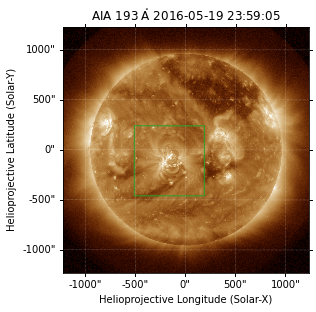

In [46]:
fig = plt.figure(figsize=(15,5))
for i,m in enumerate([m_aia]):
    ax = fig.add_subplot(1,3,i+1,projection=m)
    m.plot(axes=ax,clip_interval=(1,99.99)*u.percent)
    #ax.plot_coord(ar_center_corrected, marker='o', ls='', color='C3')
    blc = SkyCoord(Tx=ar_center.Tx-ar_width/2,
                   Ty=ar_center.Ty-ar_height/2,
                   frame=m_aia.coordinate_frame)
    m.draw_quadrangle(blc, width=ar_width, height=ar_height, edgecolor='C2', lw=1)


Create cutout based on the region defined above

In [51]:
m_cutouts = []
for m in [m_aia]:
    # the ar center is rotated prior to submapping such that the selection is aligned with the coordinate grid
    transformed_diffrot_point = ar_center.transform_to(m_aia.coordinate_frame)
    blc = SkyCoord(Tx=transformed_diffrot_point.Tx-ar_width/2,
                   Ty=transformed_diffrot_point.Ty-ar_height/2,
                   frame=m.coordinate_frame)
    m_rot = m.rotate(missing=0.0)
    m_cutout = m_rot.submap(blc, width=ar_width, height=ar_height)
    m_cutouts.append(m_cutout)


In [68]:
print(m_aia.meta['date'][:10])

2016-05-23


<Figure size 1080x360 with 0 Axes>

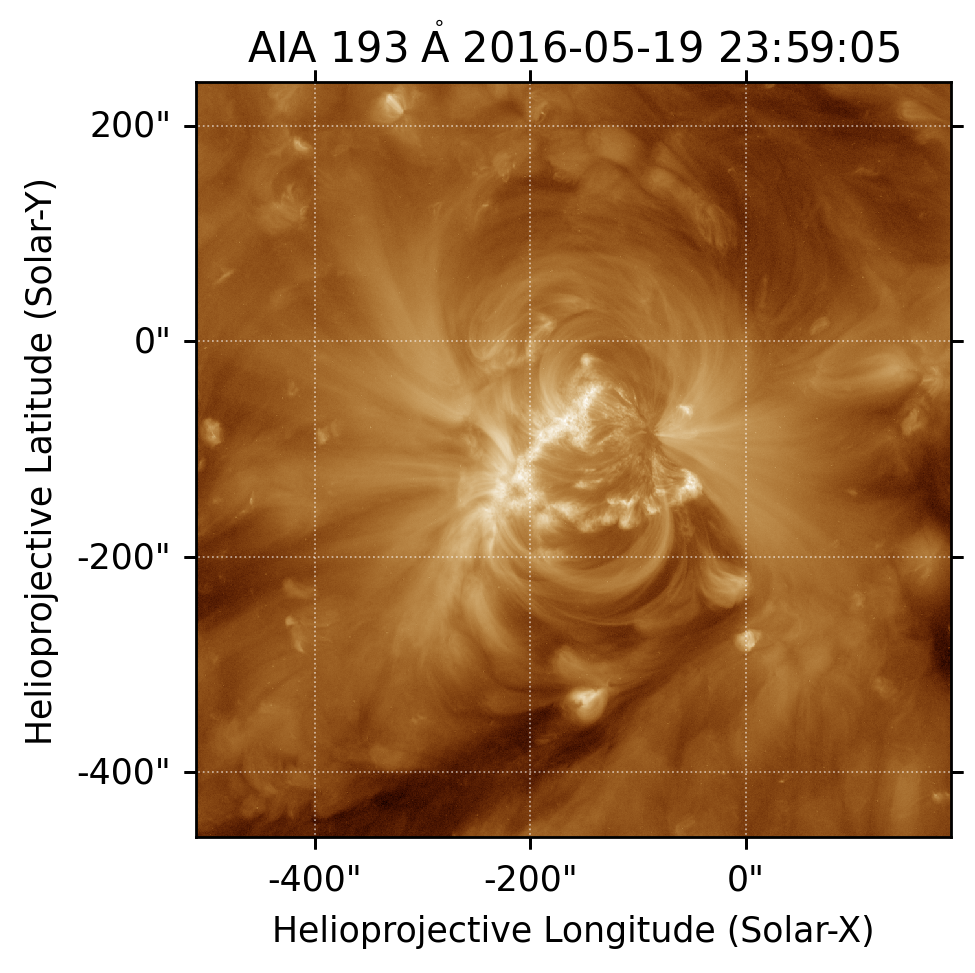

In [69]:
fig = plt.figure(figsize=(15,5))
for i,m in enumerate(m_cutouts):
    output_dir = f'images/{m.meta["wavelnth"]}/{m.meta["date"][:10]}'
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    fig = plt.figure()
    fig.set_dpi(250)
    m.plot()
    plt.savefig(f'{output_dir}/AIA_{m.meta["wavelnth"]}_{m.meta["date"].replace(":","_")}.png')
